<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/TimeSeries%20ClickCast%20(GRU%20Model)/DailyClick_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset and Setup enviorment

In [ ]:
# Load dataset and Setup enviorment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler('app.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

In [ ]:
# Setup Randomness
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset

In [ ]:
def load_dataset(file_path):
    """
    Loads the dataset from a CSV file and returns a DataFrame with date and target columns.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing 'Date' and 'Page.Loads' columns.

    Raises:
        ValueError: If file_path is empty or 'Page.Loads' column is missing.
        FileNotFoundError: If the CSV file is not found.
    """
    try:
        logger.info("Loading dataset...")

        if not file_path:
            logger.error("No file path provided for dataset!")
            raise ValueError("Dataset file path is required!")

        # Load CSV without setting index, keep 'Date' as a column
        df = pd.read_csv(file_path, parse_dates=['Date'])

        # Check if required columns exist
        if 'Page.Loads' not in df.columns:
            logger.error(f"'Page.Loads' column not found in dataset! Available columns: {list(df.columns)}")
            raise ValueError(f"'Page.Loads' column not found! Available columns: {list(df.columns)}")

        if 'Date' not in df.columns:
            logger.error(f"'Date' column not found in dataset! Available columns: {list(df.columns)}")
            raise ValueError(f"'Date' column not found! Available columns: {list(df.columns)}")

        # Select only required columns
        df = df[['Date', 'Page.Loads']]
        logger.info(f"Dataset loaded successfully: {df.shape[0]} rows, columns: {list(df.columns)}")

        return df

    except FileNotFoundError:
        logger.error(f"Dataset file not found at: {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error loading dataset: {str(e)}")
        raise

In [ ]:
# Use function to laod dataset
file_path = "/content/daily-website-visitors.csv"
data = load_dataset(file_path)

In [ ]:
# Check dataframe
data.head(3)

,Date,Page.Loads
0,2014-09-14,"2,146"
1,2014-09-15,"3,621"
2,2014-09-16,"3,698"


# Preprocessing

In [ ]:
def prepare_time_series(data=None, target_column='Page.Loads', date_column='Date', seq_length=30, train_split=0.8):
    """
    Prepares time series data for GRU model training.

    Args:
        data (pd.DataFrame, optional): DataFrame containing date and target columns (e.g., Page.Loads).
                                      If None, synthetic data is generated.
        target_column (str): Name of the target column (default: 'Page.Loads').
        date_column (str): Name of the date column (default: 'Date').
        seq_length (int): Length of sequences for prediction (default: 30).
        train_split (float): Proportion of data for training (default: 0.8).

    Returns:
        tuple: (X_train, X_test, y_train, y_test, scaler)
            - X_train, X_test: Training and testing input sequences.
            - y_train, y_test: Training and testing target values.
            - scaler: MinMaxScaler object used for normalization.

    Raises:
        ValueError: If required columns are missing, data is insufficient, or all values are invalid.
        Exception: For other preprocessing errors.
    """
    try:
        logger.info("Starting time series preprocessing...")

        # Use synthetic data if no data is provided
        if data is None:
            logger.info("No data provided, generating synthetic data...")
        else:
            df = data.copy()

        # Log initial data shape and columns
        logger.info(f"Initial data shape: {df.shape}, columns: {list(df.columns)}")

        # Convert date column to datetime
        logger.info(f"Converting '{date_column}' column to datetime...")
        if date_column not in df.columns:
            available_columns = list(df.columns)
            logger.error(f"Column '{date_column}' not found! Available columns: {available_columns}")
            raise ValueError(f"Column '{date_column}' not found! Available columns: {available_columns}")

        try:
            df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
            if df[date_column].isna().any():
                logger.warning(f"{df[date_column].isna().sum()} invalid date values converted to NaT! Dropping...")
            df = df.dropna(subset=[date_column])  # Drop rows with missing dates
            df = df.set_index(date_column).sort_index()  # Set index and sort by date
            logger.info(f"Rows after date conversion: {len(df)}")
        except Exception as e:
            logger.error(f"Error converting dates: {str(e)}")
            raise

        # Convert target column to numeric
        logger.info(f"Converting '{target_column}' column to numeric...")
        if target_column not in df.columns:
            available_columns = list(df.columns)
            logger.error(f"Column '{target_column}' not found! Available columns: {available_columns}")
            raise ValueError(f"Column '{target_column}' not found! Available columns: {available_columns}")

        try:
            # Try to clean and convert to numeric
            df[target_column] = pd.to_numeric(df[target_column].replace({',': ''}, regex=True), errors='coerce')
            nan_count = df[target_column].isna().sum()
            if nan_count > 0:
                logger.warning(f"{nan_count} invalid '{target_column}' values! Filling with median...")
                df[target_column].fillna(df[target_column].median(), inplace=True)
            if df[target_column].isna().all():
                logger.error("All values in '{target_column}' are invalid or NaN!")
                raise ValueError(f"All values in '{target_column}' are invalid or NaN!")
            logger.info(f"Target column stats - Mean: {df[target_column].mean():.2f}, Std: {df[target_column].std():.2f}, NaN count: {nan_count}")
        except Exception as e:
            logger.error(f"Error converting '{target_column}' to numeric: {str(e)}")
            raise

        # Normalize the data
        logger.info("Normalizing data with MinMaxScaler...")
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[[target_column]].values)
        if np.isnan(scaled_data).any():
            logger.error("Scaled data contains NaN values!")
            raise ValueError("Scaled data contains NaN values!")
        logger.info(f"Normalized data shape: {scaled_data.shape}")

        # Create sequences
        logger.info(f"Creating sequences with length {seq_length}...")
        X, y = [], []
        for i in range(len(scaled_data) - seq_length):
            X.append(scaled_data[i:i + seq_length])
            y.append(scaled_data[i + seq_length])

        X = np.array(X)
        y = np.array(y)
        if np.isnan(X).any() or np.isnan(y).any():
            logger.error("Sequences contain NaN values!")
            raise ValueError("Sequences contain NaN values!")
        logger.info(f"Sequences created: X.shape={X.shape}, y.shape={y.shape}")

        # Split data into training and testing sets
        logger.info(f"Splitting data into training ({train_split*100}%) and testing sets...")
        train_size = int(train_split * len(X))
        if train_size < 1:
            logger.error("Insufficient data for train/test split!")
            raise ValueError(f"Number of sequences ({len(X)}) is too small for splitting!")

        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        logger.info(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

        return X_train, X_test, y_train, y_test, scaler

    except Exception as e:
        logger.error(f"Error in time series preprocessing: {str(e)}")
        raise

In [ ]:
# Call the method
X_train, X_test, y_train, y_test, scaler = prepare_time_series(
    data,
    target_column='Page.Loads',
    date_column='Date',
    seq_length=30,
    train_split=0.8
)

In [ ]:
print("X Train: ", X_train.shape)
print("X Test: ", X_test.shape)
print("y Train: ", y_train.shape)
print("y Test: ", y_test.shape)

X Train:  (1709, 30, 1)
X Test:  (428, 30, 1)
y Train:  (1709, 1)
y Test:  (428, 1)


# Define the Model

In [ ]:
model = Sequential([
    GRU(128, input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# check summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model and Check Performance

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0723 - mae: 0.2117 - val_loss: 0.0275 - val_mae: 0.1473
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0304 - mae: 0.1467 - val_loss: 0.0241 - val_mae: 0.1353
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0268 - mae: 0.1353 - val_loss: 0.0145 - val_mae: 0.1024
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0156 - mae: 0.0998 - val_loss: 0.0067 - val_mae: 0.0646
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0094 - mae: 0.0760 - val_loss: 0.0046 - val_mae: 0.0526
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0070 - mae: 0.0644 - val_loss: 0.0037 - val_mae: 0.0448
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0056 - mae: 0.0560 - val_loss: 0.0036 - val_mae: 0.0446
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0048 - mae: 0.0535 - val_loss: 0.0035 - val_mae: 0.0434
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.004

*Evaluatin Model*

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.0395


*Prediction*

In [ ]:
def predict_clicks(model, X_test, scaler):
    predictions = model.predict(X_test)
    # معکوس کردن نرمال‌سازی
    predictions = scaler.inverse_transform(predictions)
    y_test_true = scaler.inverse_transform(y_test)
    return predictions, y_test_true

predictions, y_test_true = predict_clicks(model, X_test, scaler)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


### Plot Accuracy

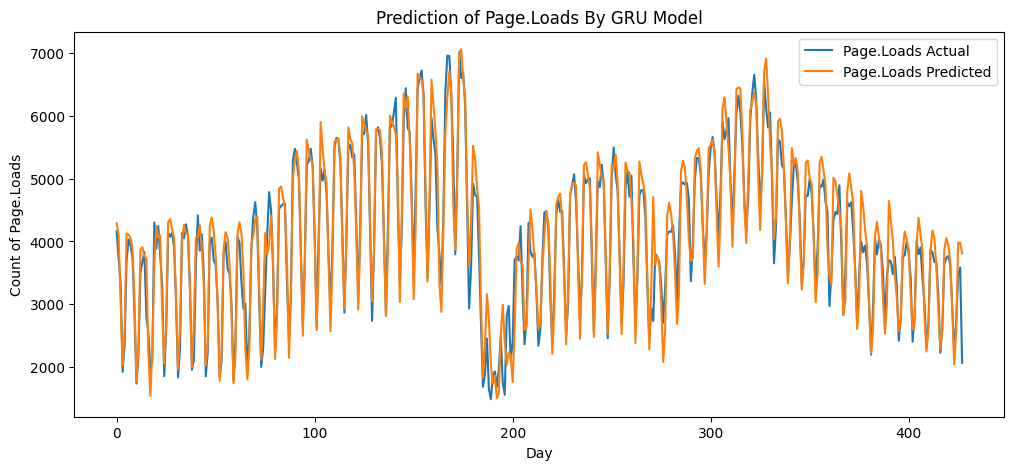

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_true, label="Page.Loads Actual")
plt.plot(predictions, label="Page.Loads Predicted")
plt.title("Prediction of Page.Loads By GRU Model")
plt.xlabel("Day")
plt.ylabel("Count of Page.Loads")
plt.legend()
plt.show()

<br><br><br>
**Making Precition on Next Days**

In [ ]:
def predict_future(model, last_sequence, scaler, n_future_days=7):
    current_sequence = last_sequence.copy()
    future_predictions = []

    for _ in range(n_future_days):
        current_sequence_reshaped = current_sequence.reshape(1, seq_length, 1)
        pred = model.predict(current_sequence_reshaped, verbose=0)
        future_predictions.append(pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred[0, 0]

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions

In [ ]:
last_sequence = X_test[-1]
future_predictions = predict_future(model, last_sequence, scaler, n_future_days=7)

In [ ]:
print("\nPrediction of Page.Loads for next 7 days:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Day {i}: {int(pred[0])} Page.Loads")


Prediction of Page.Loads for next 7 days:
Day 1: 3808 Page.Loads
Day 2: 3700 Page.Loads
Day 3: 2979 Page.Loads
Day 4: 2029 Page.Loads
Day 5: 2423 Page.Loads
Day 6: 3752 Page.Loads
Day 7: 4082 Page.Loads


## Plot Histories

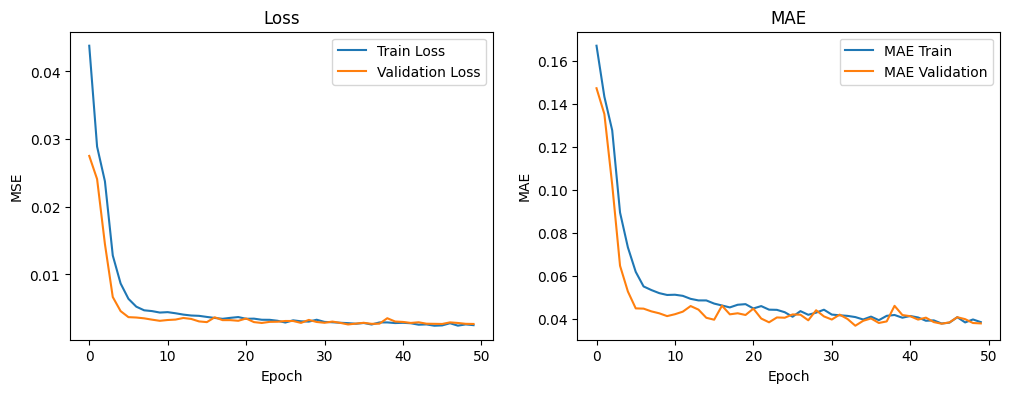

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE Train')
plt.plot(history.history['val_mae'], label='MAE Validation')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Saving the Model**

In [ ]:
model.save("gru_page_loads_prediction.h5")